In [1]:
import numpy as np
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import glob
from IPython.display import Audio, IFrame, display


In [2]:
PATH = './wav_data/'

In [3]:
angry = read(PATH + 'angry_4.wav')
angry = np.array(angry[1], dtype=float)

happy = read(PATH + 'happy_4.wav')
happy = np.array(happy[1], dtype=float)

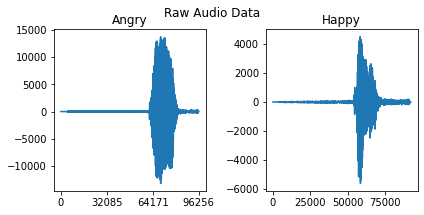

In [4]:
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.plot(angry)
plt.title('Angry')
plt.xticks(np.linspace(0, len(angry), 4))

plt.subplot(1, 2, 2)
plt.plot(happy)
plt.title('Happy')
plt.tight_layout()
plt.suptitle('Raw Audio Data')

plt.savefig('./figure/raw_data.pdf', dpi=300)
plt.show()

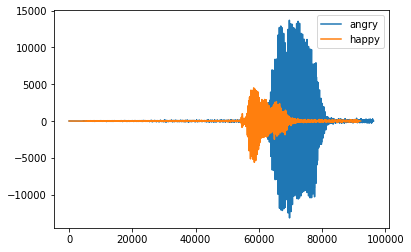

In [5]:
plt.plot(angry, label='angry')
plt.plot(happy, label='happy')
plt.legend()
plt.show()

In [6]:
# iphone_sample_rate = 44.1 * 10**3

# plt.plot(normalize_data(angry), label='angry', alpha=0.5)
# plt.plot(normalize_data(happy), label='happy', alpha=0.5)
# plt.legend()
# plt.title('Normalized data')
# # plt.xticks(np.linspace(0, len(angry) / iphone_sample_rate, 10))
# # plt.xticks([0, len(angry) / iphone_sample_rate])
# plt.ylabel('Intensity')
# plt.xlabel('second * $10^{-4}$')
# plt.show()

In [7]:
def convert_db(data):
    converted_data = []
    for d in data:
        if d != 0:
            converted_data.append(20 * np.log10(abs(d)))
        else:
            converted_data.append(0)
    converted_data = np.array(converted_data)
    return np.trim_zeros(converted_data)

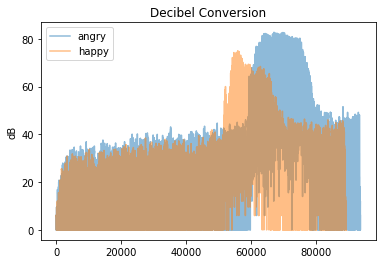

In [8]:
plt.plot(convert_db(angry), label='angry', alpha=0.5)
plt.plot(convert_db(happy), label='happy', alpha=0.5)
plt.legend()
plt.title('Decibel Conversion')
plt.ylabel('dB')
plt.show()

## What to do tomorrow (4/17)
1. ~~import bunch of audio files~~
2. ~~add a label (angry = 0, happy = 1)~~
3. ~~save them as numpy in a folder~~
4. construct a CNN model

In [9]:
from preprocessing import *
from scipy.io import wavfile

In [10]:
df = pd.read_csv('./dataframe.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
# df.drop('duration(sec)', axis=1, inplace=True)
df

,filename,class,classID,duration
0,angry_8.wav,angry,0,1.856000
1,angry_9.wav,angry,0,2.026667
2,angry_45.wav,angry,0,1.920000
3,angry_44.wav,angry,0,1.173333
4,angry_40.wav,angry,0,1.216000
...,...,...,...,...
82,angry_4.wav,angry,0,2.005333
83,happy_2.wav,happy,1,2.432000
84,happy_44.wav,happy,1,1.130667
85,happy_3.wav,happy,1,1.920000


### add duration column in the data frame

In [11]:
path = './wav_data/'
dir_list = list(df['filename'])
duration = []
for file in dir_list:
    PATH = path + file
    sample_rate, data = wavfile.read(PATH)
    time = len(data) / sample_rate
    duration.append(time)

In [12]:
## duration is in second
df['duration'] = duration
df.to_csv('./dataframe.csv')
df

,filename,class,classID,duration
0,angry_8.wav,angry,0,1.856000
1,angry_9.wav,angry,0,2.026667
2,angry_45.wav,angry,0,1.920000
3,angry_44.wav,angry,0,1.173333
4,angry_40.wav,angry,0,1.216000
...,...,...,...,...
82,angry_4.wav,angry,0,2.005333
83,happy_2.wav,happy,1,2.432000
84,happy_44.wav,happy,1,1.130667
85,happy_3.wav,happy,1,1.920000


In [13]:
## spectrogram

In [14]:
from scipy.signal import spectrogram
import sounddevice as sd

In [17]:
path = './trimmed_data/angry_1.npy'
angry_data = np.load(path)
sample_rate = 48 * 10 ** 3
sample_freq, seg_times, Sxx = spectrogram(angry_data, fs=sample_rate)

In [18]:
sd.play(angry_data, sample_rate)

## Data Preprocessing

### Denoising
0. Use Logmel-spectogram to visually confirm noises
1. Filter low-frequencies
2. PCEN
3. Spectral Gating

reference: https://www.kaggle.com/code/mauriciofigueiredo/methods-for-sound-noise-reduction

#### Log Mel-Spectogram

In [19]:
import librosa
import librosa.display

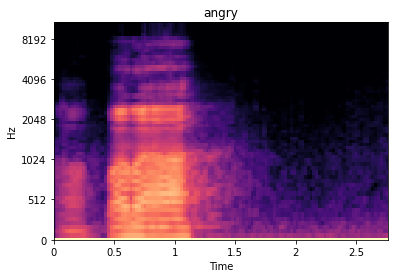

In [20]:
S1 = librosa.feature.melspectrogram(y=angry_data, sr=sample_rate, n_mels=64)
D1 = librosa.power_to_db(S1, ref=np.max)
librosa.display.specshow(D1, x_axis='time', y_axis='mel')
plt.title('angry')
plt.show()

In [21]:
path = './trimmed_data/happy_1.npy'
happy_data = np.load(path)
sample_rate = 48 * 10 ** 3
sample_freq, seg_times, Sxx = spectrogram(happy_data, fs=sample_rate)

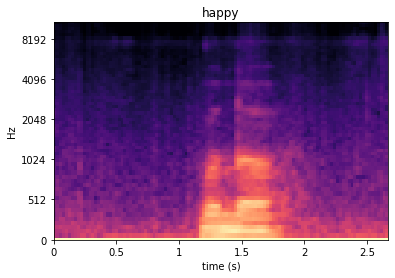

In [22]:
S2 = librosa.feature.melspectrogram(y=happy_data, sr=sample_rate, n_mels=64)
D2 = librosa.power_to_db(S2, ref=np.max)
librosa.display.specshow(D2, x_axis='time', y_axis='mel')
plt.title('happy')
plt.xlabel('time (s)')
plt.show()

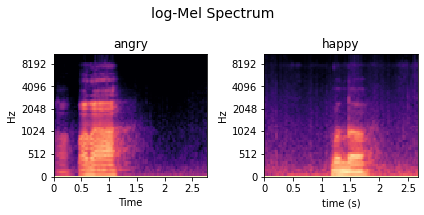

In [23]:
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
librosa.display.specshow(D1, x_axis='time', y_axis='mel')
plt.title('angry')
          
plt.subplot(1, 2, 2)
librosa.display.specshow(D2, x_axis='time', y_axis='mel')
plt.title('happy')
plt.xlabel('time (s)')

plt.suptitle('log-Mel Spectrum', fontsize=14)
plt.tight_layout()
plt.savefig('figure/log_mel_spectrum.pdf', dpi=300)
plt.show()

### Filter low-frequencies

In [24]:
from scipy.signal import lfilter, butter

In [25]:
b, a = butter(N=8, Wn=5000, btype='lowpass', fs=sample_rate)
y = lfilter(b, a, happy_data)

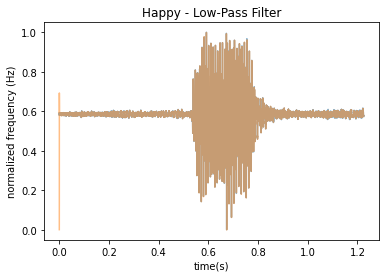

In [26]:
t = np.linspace(0, len(happy_data) / sample_rate, len(happy_data))
plt.plot(t, happy_data, alpha=0.5, label='noisy')
plt.plot(t, y, alpha=0.5, label='denoised')
plt.xlabel('time(s)')
plt.ylabel('normalized frequency (Hz)')
plt.title('Happy - Low-Pass Filter')
plt.show()

### This low-pass filtered data is not as clear as the original data

In [27]:
## filtered
sd.play(y, sample_rate)

In [28]:
## not filtered
sd.play(happy_data, sample_rate)

### PCEN (Per-Channel Energy Normalization)

In [36]:
pcen_max_angry = librosa.pcen(S=S1, sr=sample_rate)
pcen_max_happy = librosa.pcen(S=S2, sr=sample_rate)

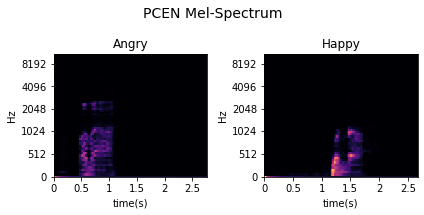

In [54]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
librosa.display.specshow(pcen_max_angry, x_axis='time', y_axis='mel')
plt.title('Angry')
plt.xlabel('time(s)')
plt.ylabel('Hz')

plt.subplot(1, 2, 2)
librosa.display.specshow(pcen_max_happy, x_axis='time', y_axis='mel')
plt.title('Happy')
plt.xlabel('time(s)')
plt.ylabel('Hz')

plt.suptitle('PCEN Mel-Spectrum', fontsize=14)
plt.tight_layout()
plt.show()

In [45]:
## convert the mel data to audio to see how the audio is filtered
pcen_angry = librosa.feature.inverse.mel_to_audio(pcen_max_angry, sr=sample_rate)
pcen_happy = librosa.feature.inverse.mel_to_audio(pcen_max_happy, sr=sample_rate)

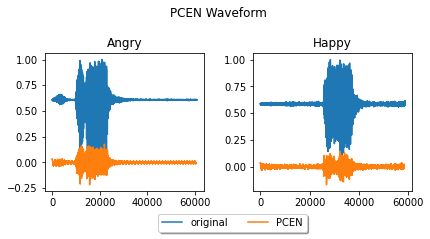

In [79]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(angry_data, label='original')
plt.plot(pcen_angry, label='PCEN')
# plt.legend()
plt.title('Angry')

plt.subplot(1, 2, 2)
plt.plot(happy_data, label='original')
plt.plot(pcen_happy, label='PCEN')
# plt.legend()
plt.title('Happy')

plt.suptitle('PCEN Waveform', fontsize=12)
plt.tight_layout()

plt.legend(loc='upper center', bbox_to_anchor=(-0.13, -0.13), fancybox=True, shadow=True, ncol=2)
plt.savefig('./figure/PCEN_waveform.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
# angry original
sd.play(angry_data, sample_rate)

In [49]:
# angry PCEN
sd.play(pcen_angry, sample_rate)

In [50]:
# happy original
sd.play(happy_data, sample_rate)

In [51]:
# happy PCEN
sd.play(pcen_happy, sample_rate)

#### The PCEN sounds are now robot-like. 
This is not what it supposed to be, so something is wrong here.

### Power Density Spectrum 

In [22]:
from scipy.fft import fft, ifft

In [23]:
df['filename'].iloc[0]

'angry_1.wav'

In [24]:
path = './trimmed_data/'
data = np.load(path+df['filename'].iloc[0].split('.')[0] + '.npy')

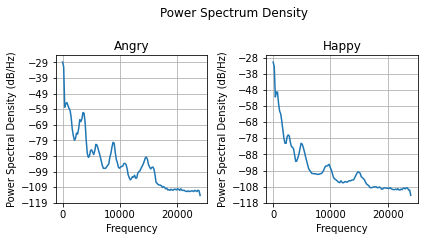

In [37]:
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
path = './trimmed_data/'
data = np.load(path+df['filename'].iloc[0].split('.')[0] + '.npy')
plt.psd(data, NFFT= 2**8, Fs=sample_rate)
plt.title('Angry')

plt.subplot(1, 2, 2)
path = './trimmed_data/'
data = np.load(path+df['filename'].iloc[-1].split('.')[0] + '.npy')
plt.psd(data, NFFT= 2**8, Fs=sample_rate)
plt.title('Happy')

plt.suptitle('Power Spectrum Density', x=0.55, y=1.1)
plt.tight_layout()
plt.savefig('./figure/psd.pdf', dpi=300)
plt.show()

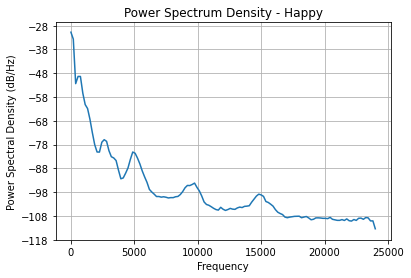

In [38]:
path = './trimmed_data/'
data = np.load(path+df['filename'].iloc[-1].split('.')[0] + '.npy')
psd, freq = plt.psd(data, NFFT= 2**8, Fs=sample_rate)
plt.title('Power Spectrum Density - Happy')
plt.show()

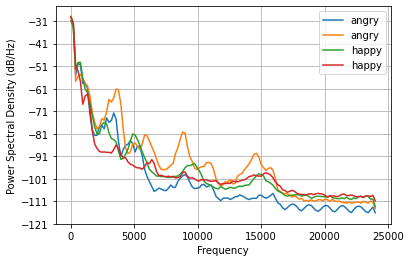

In [39]:
all_psd_happy = []
all_psd_angry = []

for npy_data in glob.glob('./trimmed_data/*.npy'):
    data = np.load(npy_data)
    label = npy_data.split('/')[-1].split('_')[0]
    
    if label == 'happy':
        psd, freq = plt.psd(data, NFFT=2**8, Fs=sample_rate, label=label)
        all_psd_happy.append(psd)
        plt.legend()
    elif label == 'angry':
        psd, freq = plt.psd(data, NFFT=2**8, Fs=sample_rate, label=label)
        all_psd_angry.append(psd)
        plt.legend()

In [319]:
all_psd_happy[0][:3], all_psd_happy[1][:3]

(array([8.44054815e-04, 4.31826713e-04, 5.80303464e-06]),
 array([1.21930925e-03, 6.31949808e-04, 7.69750152e-06]))

In [321]:
np.mean(np.array(all_psd_happy)[:, 1])

0.0005318882604848515

In [310]:
def compute_avg_psd(data):
    avg_psd = []
    for i in range(len(data[0])):
        avg_psd.append(np.mean(np.array(data)[:, i]))
    return np.array(avg_psd)

In [311]:
avg_psd_angry = compute_avg_psd(all_psd_angry)
avg_psd_happy = compute_avg_psd(all_psd_happy)

In [318]:
avg_psd_happy[:3]

array([1.03168203e-03, 5.31888260e-04, 6.75026808e-06])

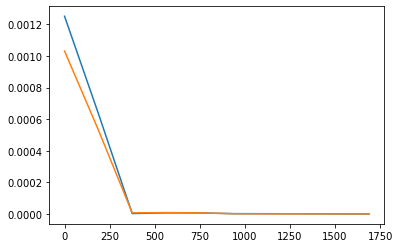

In [325]:
plt.plot(freq[:10], avg_psd_angry[:10], label='angry')
plt.plot(freq[:10], avg_psd_happy[:10], label='happy')
plt.show()

####  Taking avg psd did not preserve the original psd

### power spectrum

In [62]:
data = glob.glob('./trimmed_data/*.npy')[0]
data = np.load(data)

In [63]:
Fs = sample_rate = 48000
tstep = 1 / Fs ## sample time interval
f0 = 112 ## fundamental freq of male voices in Hz

N = int(Fs / f0) ## number of samples

In [69]:
t = np.linspace(0, (N-1) * tstep, len(data)) #time steps 
fstep = Fs / N # freq interval
freq = np.linspace(0, (N-1) * fstep, len(data))#freq steps 

In [70]:
data

array([0.57906944, 0.57906944, 0.57906944, ..., 0.58699328, 0.58481908,
       0.58143693])

In [87]:
## apply fft
X = np.fft.fft(data)
X_mag = np.abs(X) / N

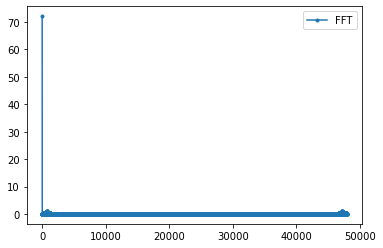

In [90]:
plt.plot(t, data, '.-', label='original signal')
plt.plot(freq, X_mag, '.-', label='FFT')
plt.legend()
plt.show()

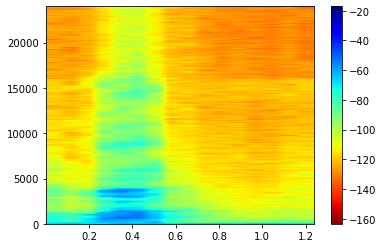

In [163]:
plt.specgram(data, NFFT=128*30, Fs=sample_rate, cmap='jet_r')
plt.colorbar()
plt.show()

In [143]:
len(sample_freq), len(seg_times), len(Sxx)

(129, 270, 129)

In [148]:
sample_freq.shape, Sxx.shape

((129,), (129, 270))

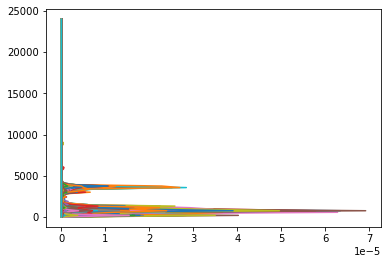

In [146]:
plt.plot(Sxx, sample_freq)
plt.show()